In [95]:
#imports
import gymnasium as gym
from gymnasium import spaces
import numpy as np
#from braid_manipulation import *
import pickle
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

try:
    from sage.all import BraidGroup
except Exception as e:
    raise RuntimeError("sagemath not found") from e

In [2]:
# braid manipulation functions

# cleanup
def cleanup(b):
    word = list(b.Tietze())
    n = b.strands()
    i = 1
    k = 1
    while (k <= n + 1 and i <= n+1):
        #print(i)
        if i not in word and -i not in word:
            #print(f"{i} not in {word}")
            if i == 1:
                #print("removing the first strand")
                for j, x in enumerate(word):
                    if x > 0:
                        word[j] = x - 1
                    else:
                        word[j] = x + 1
                i = 0
                #print(word)
            else:
                if (i - 1) not in word and -(i - 1) not in word:
                    #print(f"removing the {i} th stand")
                    for j, x in enumerate(word):
                        if abs(x) > i:
                            #print(f"chainging {x} by 1")
                            if x > 0:
                                word[j] = x -1
                            else:
                                word[j] = x + 1
                    i = i - 1
                    #print(word)
        i = i + 1
        k = k + 1
    #print(word)                   
    try:
        new_n = abs(max(word, key=abs)) + 1
    except:
        print('++++++++++++++', word)
        print(f"====== word = {word}, max = {max(word, key=abs)} max_abs+1 = {abs(max(word, key=abs))+1}")
        import sys
        sys.exit(0)
    #print(new_n)
    return BraidGroup(new_n)(word)

'''possible moves'''
# brai relation 1 : σ_i σ_i+1 σ_i = σ_i+1 σ_i σ_i+1
def find_br1(b):
    #print(b.max_crossings)
    positions = np.full(b.max_crossings - 2 , False)
    for i in range(0, b.crossings -2):
        #check if all three generators are either pos or neg and if a = c and a-b = 1
        positions[i] = ((all(b.word[i:i+3]< 0) or all(b.word[i:i+3]>0)) and
                        b.word[i] == b.word[i+2] and
                        abs(b.p_word[i] - b.p_word[i+1])== 1)
    return positions

# braid relation 2 : s_i * s_j = s_j * s_i if |i - j| >= 2
def find_br2(b):
    positions = np.full(b.max_crossings - 1 , False)
    for i in range(0, b.crossings - 1):
        positions[i] =  abs(b.p_word[i] - b.p_word[i+1])> 1
    return positions

# mm1 conjugate
def find_mm1(b):
    # if no more max no. of crossings reached, no more conjugating
    if b.crossings <= b.max_crossings -2 :
        # can only conjugate with used strands, no new strands should be used
        x = max(b.p_word)
        #print(x)
        return np.array([True] * x + [False] * (b.max_strands - 1 - x)) 
    else:
        return np.full(b.max_strands -1, False)

# stab
def find_mm2_s(b):
    return np.array([b.crossings < b.max_crossings and b.strands < b.max_strands])

# destab
def find_mm2_d(b):
    last_elem = b.p_word[-1]
    return np.array([(b.strands - 1 == last_elem) and (np.count_nonzero(b.p_word == last_elem) == 1)])

'''take actions'''
# br1 k k+1 k = k+1 k k+1
def br1(b,pos):
    new_word = b.word.copy()
    new_word[pos:pos+3] = new_word[pos+1], new_word[pos], new_word[pos+1]
    return new_word

# br2 k j = j k if |j - k| <= 2
def br2(b,pos):
    new_word = b.word.copy()
    new_word[pos:pos+2] = new_word[pos+1], new_word[pos]
    return new_word

# mm1 conjugate Braid b with the generator g
def mm1(b,g):   
    return np.concatenate([[g], b.word , [-g]])

# stab  add a strand then a crossing at the end    
def mm2_s(b):
    return np.append(b.word, max(b.p_word) + 1)

# destab remove last strand if its has only one crossing
def mm2_d(b):    
    return b.word[:-1]

# rotate
def rotate(b):
    word = b.word
    strands = b.strands
    inverted = np.empty(len(word), dtype=word.dtype)
    
    # Vectorized operations with sign flipping
    negative_mask = word < 0
    positive_mask = ~negative_mask
    
    # Flip the signs: positive becomes negative, negative becomes positive
    inverted[negative_mask] = -(word[negative_mask] + strands)
    inverted[positive_mask] = -(word[positive_mask] - strands)
    
    return inverted

In [156]:
# action braid
c = 10; s = 5
#crossing  strands
B = BraidGroup(s)

b1 = B([1,1,1])


(1, 1, 1)


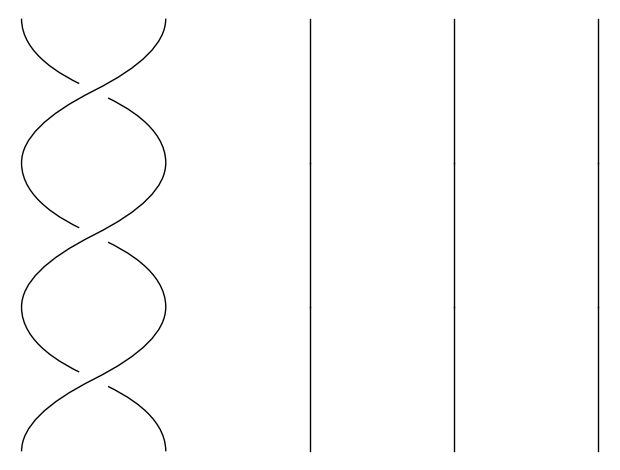

In [157]:
print(b1.Tietze())
b1.plot('black')


(2, 1, 1, 1, -2)


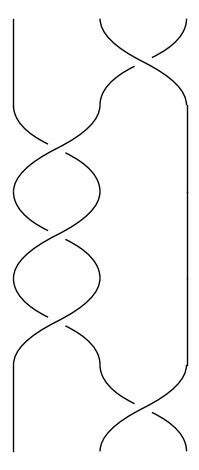

In [158]:
# markov move one conjugation
new_word = mm1(BraidEnv(b1),2)
b2 = cleanup(B(new_word.tolist()))
print(b2.Tietze())
plot(b2, 'black')

In [153]:
class BraidEnv(gym.Env):

    def __init__(self, braid, max_strands=6, max_crossings=6, max_steps=10):
        super().__init__()

        self.braid = cleanup(braid)
        self.strands = int(self.braid.strands())
        self.word = np.array(self.braid.Tietze())
        self.reset_braid = self.word
        self.p_word = abs(self.word)
        self.crossings = int(len(self.word))  # N_max 
        self.max_strands = int(max_strands)  # max strands usable (for computing, if big then transi)
        self.max_crossings = int(max_crossings)  # max number of crossing possible
        self.identified = False

        self.action_history = []
        #old braid
        self.old = {
                'word' : self.word,
                'crossings': self.crossings,
                'strands': self.strands,
                'action_info': None
            }

        #steps
        self.current_step = int(0)
        self.max_steps = max_steps

        #reward punishment values
        self.r_wrong_action = float(-15)
        self.r_identified = float(70)
        self.r_delta_crossings_mult = float(1)
        self.r_delta_strands_mult = float(0.5)
        self.r_step_m = float(-0.01)
        self.r_recurring_action = float(-5)

        # possible moves
        self.p_br1 = find_br1(self)
        self.p_br2 = find_br2(self)
        self.p_mm1 = find_mm1(self)
        self.p_mm2_s = find_mm2_s(self)
        self.p_mm2_d = find_mm2_d(self)
        self.p_rotate = np.array([True])
        self.action_len = int(2 * max_crossings + max_strands - 1)
        self.action_mask = np.concatenate([self.p_br1, self.p_br2, self.p_mm1, self.p_mm2_s, self.p_mm2_d, self.p_rotate])

        self.action_space = spaces.Discrete(self.action_len)
        self.observation_space = spaces.Dict({
                                # since word length can range from 2 to max_
            'state': spaces.Box(low=int(-self.max_strands), high=self.max_strands, shape = (int(self.max_crossings),), dtype=int),
            # fix actions_mask the shape. check if the formula works.
            'action_mask': spaces.Box(low=int(0), high=int(1), shape=(self.action_len,), dtype=bool)
        })
    def _padded_word(self):
        padded = np.full(self.max_crossings, int(0), dtype=int)
        padded[:self.crossings] = self.word
        return padded

    # get current observation
    def _get_obs(self):
        return {
            'state': self._padded_word(),
            'action_mask':  self.action_mask
        }

    def _identify_braid(self):
        if self.crossings <= 2:
            print(f"is an unkot")

        pickle_file = '/Users/khanal/dev/knoten-theorie/rl-project/data/knotinfo_dupm.pkl'
        with open(pickle_file, 'rb') as f:
            knot_dict = pickle.load(f)

        # to stirngs with no space as keys
        braid_key = str(self.word.tolist()).replace(' ', '')
        knot = knot_dict.get(braid_key, False) 
        if knot:
            print(f" The Knot is {knot['Name']} and the braid is {braid_key} ")
            return True
        else:
            return False




    def _get_reward(self, action_info):
        
        # change in braid
        crossing_delta = self.old['crossings'] - self.crossings
        strand_delta = self.old['strands'] - self.strands
        reward = self.r_delta_crossings_mult * crossing_delta + self.r_delta_strands_mult * strand_delta

        if self.old['action_info'] :
            if (len(action_info) == 1): # could be rotate, mm2_s, mm2_d
                if (self.old['action_info'][0] == 'rotate' and
                    self.old['action_info'] == action_info):
                    reward = self.r_recurring_action
            else: #is either br1 or br 2
                if (self.old['action_info'][0] == 'br1' and action_info[0] == 'br1'):
                    reward = self.r_recurring_action
                elif (self.old['action_info'][0] == 'br2' and action_info[0] == 'br2'):
                    reward = self.r_recurring_action
    
        # step punishment
        reward += self.r_step_m * self.current_step

        # braid identified
        if self._identify_braid():
            reward = self.r_identified
            print(f" the braid was identified, reward: {reward}")

        return float(reward)





    def _get_action_info(self, i):
        c = self.max_crossings; s = self.max_strands
        if self.action_mask[i]: # only if its true then its a valid action
            if i <= c-3:
                return ['br1', i]
            elif i <= 2*c - 4:
                return ['br2',i- c + 2]
            elif i<= 2*c + s - 5 :
                return ['mm1', i - 2 * c + 4]
            elif i<=(2 * c + s - 4):
                return ['mm2_s']
            elif i <= (2 * c + s -3):
                return ['mm2_d']
            elif i<=( 2* c + s - 2):
                return ['rotate']
        else:
            return False

    def _new_state(self, word):
        new_len = len(word)
        try: 
            new_strands = abs(max(abs(word))) + 1
        except: 
            print(f"_new_state error caused by the braid {word}")
            return
        #print(f"new_strands: {new_strands}, word: {word}")
        braid = BraidGroup(new_strands)(word.tolist())
        #print(f"new_len: {new_len}, new_strands: {new_strands}")
        if new_len <= self.max_crossings or new_strands <= self.max_strands:
            '''updating state'''
            self.braid = cleanup(braid)
            self.strands = self.braid.strands()
            self.word = np.array(self.braid.Tietze())
            self.p_word = abs(self.word)
            self.crossings = int(len(self.word))

            '''updating action_mask'''
            self.p_br1 = find_br1(self)
            self.p_br2 = find_br2(self)
            self.p_mm1 = find_mm1(self)
            self.p_mm2_s = find_mm2_s(self)
            self.p_mm2_d = find_mm2_d(self)
            self.p_rotate = np.array([True])
            self.action_len = int(2 * self.max_crossings + self.max_strands - 1)
            self.action_mask = np.concatenate([self.p_br1, self.p_br2, self.p_mm1, self.p_mm2_s, self.p_mm2_d, self.p_rotate])

        else:
            print(f"error when creating the new state, no. strands: {new_strands}, new crossings: {new_len} ")
            return None

    def _apply_action(self, action_info):
        m = action_info[0]
        if m == 'br1':
            new_braid = br1(self,action_info[1])
        elif m == 'br2':
            new_braid =  br2(self,action_info[1])
        elif m == 'mm1':
            new_braid =  mm1(self, action_info[1])
        elif m == 'mm2_s':
            new_braid =  mm2_s(self)
        elif m == 'mm2_d':
            new_braid =  mm2_d(self)
        elif m == 'rotate':
            new_braid =  rotate(self)
        else:
            print('from the apply action got an invalid action: ', action_info)
            return None
        if len(new_braid)== 1:
            print(f"trival braid {new_braid}")
        self._new_state(new_braid)
        return new_braid

    def _get_info(self, action=None):
        info = {
            "braid_word": self.word,
            "action_mask": self.action_mask,
            "current_step": self.current_step,
            }
        if action:
            info["action"] = self._get_action_info(action)
        return info

    def step(self, action):

        action_info = self._get_action_info( action)
        self.action_history.append(action_info)

        # if move leagal do the move and then calc the reward, if move illeagal punish
        if action_info and self.current_step <= self.max_steps :
            self._apply_action(action_info)
            reward = self._get_reward(action_info=action_info)
            self.old['action_info'] = action_info
            print(f"action {action_info} => {self.word}")
        else:
            reward = self.r_wrong_action

        self.current_step += 1
        self.old = {
                'word' : self.word,
                'crossings': self.crossings,
                'strands': self.strands,
                'action_info': self.old['action_info']
            }
        #print(f"reward for this step: {reward}")
        observation = self._get_obs()

        terminated = self._identify_braid()
        truncated = self.current_step > self.max_steps
        info = self._get_info(action=action)
        #print(f"=====================end of step {self.current_step}==========================")
        
        return observation, reward, terminated, truncated, info

    # redundent code but the maskablePPO needs this function
    def get_action_mask(self):
        return self.action_mask

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self._new_state(self.reset_braid)
        self.action_history = []
        self.old = {
            'word' : self.word,
            'crossings': self.crossings,
            'strands': self.strands,
            'action_info': None
        }
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def render(self, mode="human"):
        print(f"Step: {self.current_step}")
        print(f"Current braid word: {self.word}")
        print(f"Actions taken so far: {self.action_history}")
    
    def close(sefl):
        pass


In [ ]:
c = 9; s = 5
B = BraidGroup(s)
#b = B([5,-4,5,4,3,-2,3,-4,3,2,1,-2,1,-4,-3,-3,-2])
b= B([-2,1,1,1,2])

def mask_fn(env):
    # Return a numpy array of shape (n_actions,), dtype bool or int (0/1)
    return env.get_action_mask()

env = BraidEnv(b, max_crossings=c, max_strands=s, max_steps= 10)
env = ActionMasker(env, mask_fn)

check_env(env)  # optional, but can help catch issues

model = MaskablePPO("MultiInputPolicy", env, verbose=0)
model.learn(total_timesteps=5)


<<<<<<$$$$0>>>>>> wrong action;;; action_info: False ;;;; with old action: None
(((<<<***1***>>>))) got Invalid Action so reward: -5.0
=====================end of step 1==========================
<<<<<<0>>>>>> old action info  old_action_info:None   action_info: ['mm2_s']
(((<<<1>>>))) ['mm2_s']
(((<<<2>>>))) [-2  1  1  1  2] with <<['mm2_s']>> and got == [-2  1  1  1  2  3]
(((<<<3>>>))) logging ['mm2_s'] with its bool value None info from get reward ['mm2_s']
(((<<<4>>>)))reward after this action: -1.5
=====================end of step 1==========================
<<<<<<$$$$0>>>>>> wrong action;;; action_info: False ;;;; with old action: ['mm2_s']
(((<<<***1***>>>))) got Invalid Action so reward: -5.0
=====================end of step 2==========================
<<<<<<$$$$0>>>>>> wrong action;;; action_info: False ;;;; with old action: ['mm2_s']
(((<<<***1***>>>))) got Invalid Action so reward: -5.0
=====================end of step 3==========================
<<<<<<0>>>>>> old action in

In [141]:
c = 10
s = 5
B = BraidGroup(s)

# random braid generator
import random

def rbg(B, crossing_n):
    while True:
        n = B.strands() - 2
        word = []
        for i in range(0,crossing_n-2):
            if randint(0,1) :
                word.append(randint(1,n))
            else:
                word.append(- randint(1,n))
        braid = B(word)
        if Link(braid).is_knot():
            return braid

braid_list = [rbg(B,randint(5,c)) for i in range(3)]
# print the braid list for example
#braid_list = []
braid_list.append(B([2,1,1,1,-2]))
braid_list.append(B([1,2,1,1,1,-2,3,-1]))
braid_list.append(B([2,1,2,1,1,-2,3,-1,3]))
braid_list.append(B([3,1,1,1,1,-2,1,-2, -1,3]))
[print(braid_list[i].Tietze()) for i in range(7)]

(1, 1, 2, 1)
(2, 1, 1, 2, -1, 2, 3)
(-1, 3, 1, 1, 2)
(2, 1, 1, 1, -2)
(1, 2, 1, 1, 1, -2, 3, -1)
(2, 1, 2, 1, 1, -2, 3, -1, 3)
(3, 1, 1, 1, 1, -2, 1, -2, -1, 3)


[None, None, None, None, None, None, None]

In [154]:
def mask_fn(env):
    return env.get_action_mask()

model_path = f"/Users/khanal/dev/knoten-theorie/rl-project/data/ppo_braid_{c}_{s}"

model = None
total_timesteps = 40

for i, b in enumerate(braid_list):
    print(f"<<=== Training on braid {i+1}/{len(braid_list)}: {b.Tietze()} ===>>")

    env = BraidEnv(b, max_crossings = c, max_strands= s, max_steps = 20)
    env = ActionMasker(env, mask_fn)
    
    check_env(env)

    # initializing the model
    if model is None:
        model = MaskablePPO("MultiInputPolicy",
                    env,
                    verbose=1,
                    learning_rate=float(2e-4),
                    clip_range = float(0.2),
                    gamma=float(0.96), 
                    device="mps"
                    )
    else:
        model.set_env(env)
    
    model.learn(total_timesteps=total_timesteps)

    model.save(model_path)

    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)
    print(f"Mean reward: {mean_reward} +/- {std_reward}")

print("Finished tranning on the braids. ")

<<=== Training on braid 1/7: (1, 1, 2, 1) ===>>
action ['mm1', np.int64(1)] => [1 1 1 2]
 The Knot is 3_1 and the braid is [1,1,1] 
 the braid was identified, reward: 70.0
action ['mm2_d'] => [1 1 1]
 The Knot is 3_1 and the braid is [1,1,1] 
action ['br1', np.int64(1)] => [1 2 1 2]
Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
action ['mm1', np.int64(2)] => [ 2  1  1  2  1 -2]
action ['mm1', np.int64(1)] => [ 1  2  1  1  2  1 -2 -1]
action ['br1', np.int64(3)] => [1 2 1 2]
action ['mm1', np.int64(2)] => [2 1 2 1]
action ['mm2_s'] => [2 1 2 1 3]
action ['mm1', np.int64(1)] => [ 1  2  1  2  1  3 -1]
action ['br1', np.int64(2)] => [ 1  2  2  1  2  3 -1]
action ['mm1', np.int64(3)] => [ 3  1  2  2  1  2  3 -1 -3]
action ['mm2_s'] => [ 3  1  2  2  1  2  3 -1 -3  4]
action ['mm2_d'] => [ 3  1  2  2  1  2  3 -1 -3]
action ['br2', np.int64(6)] => [ 3  1  2  2  1  2 -1]
action ['rotate'] => [ 1  3  2  2  3  2 -3]
action ['mm1', np.int64(3)] => [ 

In [87]:
# test

model = MaskablePPO.load(model_path)

b = rbg(B, 7)
b.Tietze()

(-2, 3, -2, -2, 1)

In [162]:
env = BraidEnv(B([1,1,2,1]), max_crossings=c, max_strands=s, max_steps=50)
env = ActionMasker(env, mask_fn)

obs, _ = env.reset()
done, truncated = False, False

while not (done or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

Step: 1
Current braid word: [1 1 2 1]
Actions taken so far: [False]
Step: 2
Current braid word: [1 1 2 1]
Actions taken so far: [False, False]
Step: 3
Current braid word: [1 1 2 1]
Actions taken so far: [False, False, False]
Step: 4
Current braid word: [1 1 2 1]
Actions taken so far: [False, False, False, False]
Step: 5
Current braid word: [1 1 2 1]
Actions taken so far: [False, False, False, False, False]
Step: 6
Current braid word: [1 1 2 1]
Actions taken so far: [False, False, False, False, False, False]
Step: 7
Current braid word: [1 1 2 1]
Actions taken so far: [False, False, False, False, False, False, False]
Step: 8
Current braid word: [1 1 2 1]
Actions taken so far: [False, False, False, False, False, False, False, False]
Step: 9
Current braid word: [1 1 2 1]
Actions taken so far: [False, False, False, False, False, False, False, False, False]
Step: 10
Current braid word: [1 1 2 1]
Actions taken so far: [False, False, False, False, False, False, False, False, False, False]
Step